In [1]:
import numpy as np
import os.path
import math
import pandas as pd
from sklearn.preprocessing.label import LabelBinarizer
from keras.applications import VGG16, InceptionResNetV2
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler
from matplotlib import pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
# updatable plot
# a minimal example (sort of)
# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# Using feature extraction for image classification

## Extract feature

extract feature from dataset

In [3]:
batch_size = 16
datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(
    'data/train',
    target_size=(225, 225),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

validation_generator = datagen.flow_from_directory(
    'data/validation',
    target_size=(225, 225),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

test_generator = datagen.flow_from_directory(
    'data/test',
    target_size=(225, 225),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

# model for feature extraction
inc = InceptionResNetV2(include_top=False, weights='imagenet', pooling='avg')

features_train = inc.predict_generator(
        train_generator,
        steps=len(train_generator.filenames),
        verbose=1)

features_valid = inc.predict_generator(
        validation_generator,
        steps=len(validation_generator.filenames),
        verbose=1)
# features_test = extract_feature(test_generator)

Found 8185 images belonging to 120 classes.
Found 2037 images belonging to 120 classes.
Found 10357 images belonging to 1 classes.
159/512 [========>.....................] - ETA: 1:54

KeyboardInterrupt: 

## Create full network model

In [55]:
model = Sequential()
model.add(Dense(256, input_shape=features_train.shape[1:], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(120, activation='softmax'))

## Train network

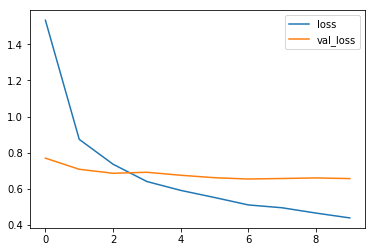

In [56]:
def lr_schedule(epoch):
    return lr * math.pow(0.5, math.floor((1+epoch)/10.0))

epochs = 10
lr = 0.01
decay_rate = lr / epochs
sgd = SGD(lr=lr, momentum=0.9, decay=decay_rate, nesterov=True)
model.compile(
    optimizer=sgd, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

train_labels = to_categorical(train_generator.classes, num_classes=num_classes)
valid_labels = to_categorical(validation_generator.classes, num_classes=num_classes)

model.fit(features_train, train_labels,
          epochs=epochs,
          batch_size=16,
          validation_data=(features_valid, valid_labels),
         callbacks=[plot_losses],
         verbose=0)

In [52]:
print(features_valid.shape)
print(features_train.shape)
print(features_test.shape)

(2037, 1536)
(8185, 1536)
(10357, 1536)


## Predict on test data

In [7]:
predict = model.predict(features_test, verbose=1)

10357/10357 [==============================] - 1s 65us/step


In [8]:
data = {}
filenames = [i.split(".")[0].replace("test/", "") for i in test_generator.filenames]

for k, v in train_generator.class_indices.items():
    data[k] = predict[:, v]


    dt = pd.DataFrame(data)
dt.insert(0, "id", filenames)
dt

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.003075,0.018604,0.005653,0.007415,0.007603,0.005098,0.004374,0.003841,0.018957,...,0.002871,0.002025,0.006667,0.006060,0.013690,0.013673,0.002028,0.010899,0.003474,0.004486
1,00102ee9d8eb90812350685311fe5890,0.001753,0.003416,0.003732,0.001837,0.006142,0.001003,0.012423,0.012284,0.003695,...,0.003886,0.008173,0.002261,0.002322,0.002089,0.002269,0.005336,0.011648,0.002835,0.003129
2,0012a730dfa437f5f3613fb75efcd4ce,0.009619,0.011076,0.001969,0.016543,0.007319,0.003485,0.004071,0.004483,0.002804,...,0.006494,0.003494,0.004594,0.003668,0.005250,0.004343,0.004975,0.010421,0.004702,0.003583
3,001510bc8570bbeee98c8d80c8a95ec1,0.004281,0.008430,0.004064,0.010600,0.013311,0.006859,0.002312,0.029212,0.007845,...,0.006732,0.005321,0.008104,0.008952,0.006938,0.003973,0.001334,0.011114,0.004979,0.003855
4,001a5f3114548acdefa3d4da05474c2e,0.012417,0.013479,0.004373,0.009999,0.006700,0.001746,0.012778,0.003028,0.003033,...,0.003788,0.003071,0.003838,0.002051,0.002942,0.005473,0.007537,0.003515,0.009706,0.005682
5,00225dcd3e4d2410dd53239f95c0352f,0.005307,0.016677,0.003867,0.006179,0.003267,0.002580,0.005117,0.004960,0.003385,...,0.004531,0.001761,0.006966,0.003195,0.006682,0.006682,0.003938,0.010861,0.007312,0.002927
6,002c2a3117c2193b4d26400ce431eebd,0.005343,0.005738,0.006658,0.005830,0.004837,0.003549,0.018506,0.008639,0.004691,...,0.003325,0.010196,0.002006,0.000731,0.002326,0.003082,0.031718,0.003479,0.007036,0.010757
7,002c58d413a521ae8d1a5daeb35fc803,0.003973,0.003317,0.000799,0.001527,0.002067,0.000189,0.022180,0.002133,0.000373,...,0.004187,0.004090,0.000647,0.000064,0.000464,0.000748,0.063012,0.000333,0.007004,0.007950
8,002f80396f1e3db687c5932d7978b196,0.011790,0.013539,0.020716,0.017716,0.005287,0.003527,0.013048,0.003864,0.002724,...,0.005028,0.001866,0.003622,0.002927,0.007789,0.004657,0.008612,0.006742,0.003872,0.009297
9,0036c6bcec6031be9e62a257b1c3c442,0.005755,0.011585,0.002503,0.009302,0.011091,0.003052,0.007959,0.001722,0.006535,...,0.003539,0.002741,0.003343,0.001978,0.004068,0.006483,0.003930,0.001573,0.004077,0.006136


In [10]:
dt.to_csv('predictions.csv', index=False)